### Import Dependencies

In [1]:
import pandas as pd
import numpy as np  # NumPy untuk komputasi numerik
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
import datetime as dt  # Manipulasi data waktu dan tanggal
import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
import csv
import requests
from io import StringIO
import pickle

from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks
from nltk.stem import WordNetLemmatizer
from nltk import download as nltk_download
nltk_download('punkt_tab')
nltk_download('stopwords')
nltk_download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

!pip install scikit-optimize
from skopt import BayesSearchCV

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load Dataset

In [2]:
drive= "https://drive.google.com/uc?id=1P7nTVIbsZxUTkPjydnlMvP26KUMCn4WZ"
local = "./data/ulasan_game_coc.csv"

# df = pd.read_csv(local) # jika menggunakan local env
df = pd.read_csv(drive) # jika menggunakan google colab
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,6cedfaca-247b-4209-a285-39d04ab59e63,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Clash of clans sekarang sering gangguan atau l...,2,1998,16.654.16,2024-12-14 20:45:20,NaN,NaN,16.654.16
1,3396180e-09ec-4535-bb01-b117722f118d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sudah diupdate tapi kenapa ya dari dulu masala...,3,3,17.126.6,2025-03-30 20:29:02,NaN,NaN,17.126.6
2,7d669783-6878-4bda-a5be-1381b11ec532,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Update bug update terbaru : 1.utk pelatihan pa...,3,15,17.126.6,2025-03-26 20:16:26,NaN,NaN,17.126.6
3,f846cef1-1211-41e2-97f8-87012065b2ac,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aku kurangin bintang nya satu jadi bintang emp...,4,13,17.126.6,2025-03-28 18:41:24,NaN,NaN,17.126.6
4,94cca14d-5372-437e-931f-47b44577d6f8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sejauh ini setelah 9 th bermain baru ini updat...,5,111,17.126.6,2025-03-28 22:56:27,NaN,NaN,17.126.6


### Exploratory Dataset

In [3]:
# Mengecek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              30000 non-null  object 
 1   userName              30000 non-null  object 
 2   userImage             30000 non-null  object 
 3   content               30000 non-null  object 
 4   score                 30000 non-null  int64  
 5   thumbsUpCount         30000 non-null  int64  
 6   reviewCreatedVersion  24093 non-null  object 
 7   at                    30000 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appVersion            24093 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 2.5+ MB


In [4]:
# Mengecek nilai duplikat
df.duplicated().sum()

np.int64(0)

In [5]:
df.isna().sum()
df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,5907
at,0
replyContent,30000
repliedAt,30000


### Data Preprocessing

In [6]:
# Menyalin ke clean_df dari df original
clean_df = df

In [7]:
# Menghapus kolom yang tidak digunakan
clean_df = clean_df.drop(columns=['reviewId', 'userImage', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt'])
clean_df.head()

,userName,content,score,thumbsUpCount,appVersion
0,Pengguna Google,Clash of clans sekarang sering gangguan atau l...,2,1998,16.654.16
1,Pengguna Google,Sudah diupdate tapi kenapa ya dari dulu masala...,3,3,17.126.6
2,Pengguna Google,Update bug update terbaru : 1.utk pelatihan pa...,3,15,17.126.6
3,Pengguna Google,aku kurangin bintang nya satu jadi bintang emp...,4,13,17.126.6
4,Pengguna Google,Sejauh ini setelah 9 th bermain baru ini updat...,5,111,17.126.6


In [8]:
# Menghapus missing value pada kolom 'content'
clean_df = clean_df.dropna(subset=['content'])

In [9]:
# Menghapus data duplikat
clean_df = clean_df.drop_duplicates()

In [10]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29996 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   userName       29996 non-null  object
 1   content        29996 non-null  object
 2   score          29996 non-null  int64 
 3   thumbsUpCount  29996 non-null  int64 
 4   appVersion     24091 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.4+ MB


### Data Preparation

**Mendefinisikan fungsi**
1. cleaningText(text): Fungsi ini digunakan untuk membersihkan teks dengan beberapa langkah, seperti menghapus mention, hashtag, RT (retweet), tautan (link), angka, dan tanda baca. Selain itu, itu juga menggantikan karakter newline dengan spasi dan menghilangkan spasi ekstra di awal dan akhir teks.
2. casefoldingText(text): Fungsi ini mengonversi semua karakter dalam teks menjadi huruf kecil (lowercase), sehingga teks menjadi lebih seragam.
3. tokenizingText(text): Fungsi ini digunakan untuk membagi teks menjadi daftar kata atau token. Ini berguna untuk mengurai teks menjadi komponen-komponen dasar.
4. filteringText(text): Fungsi ini digunakan untuk menghapus kata-kata berhenti (stopwords) dalam teks. Anda telah memperbarui daftar kata-kata berhenti dengan beberapa kata tambahan.
5. stemmingText(text): Fungsi ini menerapkan stemming pada teks, yaitu mengurangi kata-kata menjadi bentuk dasarnya. Anda menggunakan pustaka Sastrawi untuk melakukan stemming dalam bahasa Indonesia.
6. toSentence(list_words): Fungsi ini digunakan untuk menggabungkan daftar kata-kata menjadi sebuah kalimat.

In [11]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

    return stemmed_text
def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [66]:
# Mendefinisikan slang words
slangwords = {
    "@": "di",
    "cuan": "untung",
    "parah sih": "sangat buruk",
    "anjir": "ekspresi kaget",
    "wkwk": "tertawa",
    "wkwkwk": "tertawa",
    "haha": "tertawa",
    "lol": "tertawa",
    "lmao": "tertawa keras",
    "ngakak": "tertawa keras",
    "b aja": "biasa saja",
    "bgt": "banget",
    "bngt": "banget",
    "sgt": "sangat",
    "btw": "ngomong-ngomong",
    "imo": "menurut saya",
    "imho": "menurut saya dengan rendah hati",
    "tp": "tapi",
    "jd": "jadi",
    "gmna": "bagaimana",
    "gmn": "bagaimana",
    "gk": "tidak",
    "ga": "tidak",
    "ngga": "tidak",
    "tdk": "tidak",
    "udh": "sudah",
    "sdh": "sudah",
    "blm": "belum",
    "bgt": "banget",
    "dpt": "dapat",
    "dah": "sudah",
    "ni": "ini",
    "gini": "begini",
    "gitu": "begitu",
    "mulu": "terus menerus",
    "bang": "abang",
    "sis": "kakak perempuan",
    "bro": "saudara",
    "kntl": "kata kasar",
    "anjay": "ekspresi terkejut",
    "anj": "ekspresi marah atau terkejut",
    "buggy": "banyak kesalahan",
    "broken": "tidak seimbang",
    "laggy": "lambat",
    "payah": "buruk",
    "lumayan": "cukup baik",
    "oke": "baik",
    "ok": "baik",
    "mantul": "mantap betul",
    "cocok": "sesuai",
    "ngulang": "mengulang",
    "grinding": "bermain terus untuk naik level",
    "grind": "bermain terus untuk naik level",
    "grindy": "butuh waktu lama untuk naik level",
    "ngedrop": "menurunkan",
    "ez": "mudah",
    "auto win": "pasti menang",
    "susah": "sulit",
    "gabut": "tidak ada kegiatan",
    "kece": "keren",
    "slow": "santai",
    "nt": "nice try",
    "carry": "menggendong tim",
    "feed": "mati terus dan memberi musuh keuntungan",
    "no counter": "tidak bisa dilawan",
    "cupu": "tidak mahir",
    "tim noob": "tim tidak kompeten",
    "tim jelek": "tim buruk",
    "kurang ajar": "tidak sopan",
    "auto lose": "pasti kalah",
    "mekanik jelek": "kemampuan mekanik rendah",
    "gerak patah": "lag",
    "lemot bgt": "sangat lambat",
    "pantesan": "tidak heran",
    "yg": "yang",
    "bagu": "bagus",
    "nge-lag": "lambat",
    "lemot": "lambat",
    "ngefreeze": "tidak merespons",
    "bug": "kesalahan sistem",
    "error": "kesalahan",
    "ngelag": "lambat",
    "fps drop": "turun frame rate",
    "stuck": "macet",
    "kehapus": "terhapus",
    "server ampas": "server jelek",
    "toxic": "perilaku buruk",
    "ngespam": "mengirim berulang",
    "p2w": "bayar untuk menang",
    "pay to win": "bayar untuk menang",
    "game sampah": "game jelek",
    "dev cupu": "developer tidak kompeten",
    "fix dong": "tolong perbaiki",
    "basi": "tidak menarik",
    "kurang seru": "tidak menarik",
    "gak jelas": "tidak jelas",
    "parah": "sangat buruk",
    "rip": "mati",
    "ngabisin duit": "boros uang",
    "mending uninstall": "lebih baik hapus aplikasi",
    "auto keluar": "keluar sendiri",
    "server down": "server mati",
    "game mati": "game sepi pemain",
    "gajelas": "tidak jelas",
    "hapus akun": "delete akun",
    "dc mulu": "sering terputus",
    "balancing ampas": "keseimbangan buruk",
    "matchmaking kacau": "sistem pencocokan buruk",
    "kontrol jelek": "kontrol buruk",
    "bikin kesel": "menyebalkan",
    "paywall": "harus bayar untuk lanjut",
    "kurang greget": "kurang menantang",
    "game busuk": "game jelek",
    "sering error": "sering bermasalah",
    "dev malas": "developer malas",
    "beli skin mahal": "harga skin mahal",
    "harganya gila": "terlalu mahal",
    "update gak guna": "update tidak bermanfaat",
    "event zonk": "event tidak menarik",
    "gabisa login": "tidak bisa masuk",
    "account hilang": "akun hilang",
    "data ke-reset": "data terhapus",
    "loot sedikit": "sumber daya sedikit",
    "gampang curang": "mudah diretas",
    "banyak cheater": "terlalu banyak curang",
    "noob": "pemain pemula",
    "gg": "bagus",
    "ggwp": "bagus sekali",
    "mabar": "main bareng",
    "afk": "tidak aktif",
    "sultan": "pemain kaya",
    "f2p": "gratisan",
    "p2w": "bayar untuk menang",
    "th": "balai kota",
    "th9": "balai kota 9",
    "th10": "balai kota 10",
    "th11": "balai kota 11",
    "th12": "balai kota 12",
    "th13": "balai kota 13",
    "th14": "balai kota 14",
    "th15": "balai kota 15",
    "zapquake": "mantra petir dan gempa",
    "cc": "kastil klan",
    "fwa": "aliansi perang bertani",
    "lalo": "serangan lava hound dan balon",
    "hybrid": "serangan hog rider dan penambang",
    "rush": "naik level cepat tanpa meningkatkan pertahanan",
    "maxed": "sudah ditingkatkan sepenuhnya",
    "war weight": "nilai pertahanan dalam perang",
    "edrag": "naga elektro",
    "meta": "strategi terbaik saat ini",
    "nerf": "dilemahkan",
    "buff": "diperkuat",
    "noob": "pemain pemula",
    "pro": "pemain profesional",
    "loot": "sumber daya",
    "op": "terlalu kuat",
    "base": "tata letak desa",
    "farming": "mengumpulkan sumber daya",
    "legend": "liga legenda",
    "push": "menaikkan peringkat",
    "drop trophies": "sengaja kalah untuk lawan lebih mudah",
    "clan games": "event hadiah klan",
    "cw": "perang klan",
    "cwl": "liga perang klan",
    "def": "pertahanan",
    "atk": "serangan",
    "troop comp": "komposisi pasukan",
    "strat": "strategi",
    "pekka": "pasukan ksatria robot",
    "hog": "penunggang babi",
    "drag": "naga",
    "queen walk": "strategi ratu dengan penyembuh",
    "king walk": "strategi raja barbar dengan penyembuh",
    "siege": "mesin pengepungan",
    "wb": "penghancur tembok",
    "minion": "pasukan udara kecil",
    "warden": "penjaga agung",
    "bm": "mesin pertempuran",
    "loot cart": "kereta sumber daya tambahan",
    "sc": "supercell",
    "bh": "balai tukang",
    "bh9": "balai tukang 9",
    "bh10": "balai tukang 10",
    "bh11": "balai tukang 11",
    "ngecrash": "aplikasi tertutup sendiri",
    "ngefreeze": "layar tidak merespons",
    "ngelag": "terjadi keterlambatan",
    "laggy": "lambat merespons",
    "dc": "terputus dari server",
    "stuck": "macet",
    "hang": "layar tidak bergerak",
    "relog": "masuk ulang",
    "disconnect": "terputus dari koneksi",
    "network error": "kesalahan jaringan",
    "connection lost": "koneksi terputus",
    "auto keluar": "keluar dengan sendirinya",
    "force close": "tertutup paksa",
    "fps drop": "turun kualitas frame",
    "high ping": "ping tinggi",
    "low fps": "frame per detik rendah",
    "server down": "server mati",
    "server ampas": "server buruk",
    "connection issue": "masalah koneksi",
    "bad matchmaking": "pencocokan buruk",
    "unfair match": "pertandingan tidak adil",
    "pay to win": "bayar untuk menang",
    "p2w": "bayar untuk menang",
    "f2p": "pemain gratisan",
    "gg": "hebat",
    "ggwp": "permainan bagus",
    "auto win": "pasti menang",
    "mabar": "main bersama",
    "afk": "tidak aktif",
    "spam skill": "menggunakan skill terus-menerus",
    "drop rate": "tingkat penurunan hadiah",
    "rng": "faktor keberuntungan",
    "one shot": "mati dalam satu serangan",
    "broken hero": "pahlawan terlalu kuat",
    "overpower": "terlalu kuat",
    "tim jelek": "tim buruk",
    "cupu": "tidak mahir",
    "grind": "bermain berulang-ulang",
    "grindy": "perlu usaha besar",
    "rank turun": "peringkat menurun",
    "lemot": "lambat",
    "nge-lag": "lambat merespons",
    "update": "pembaruan",
    "update jelek": "pembaruan buruk",
    "balancing ampas": "penyeimbangan buruk",
    "fix dong": "tolong diperbaiki",
    "event zonk": "acara tidak menarik",
    "ngabisin duit": "menghabiskan uang",
    "mending uninstall": "lebih baik hapus aplikasi",
    "kontrol jelek": "kontrol buruk",
    "dev malas": "pengembang malas",
    "skin mahal": "harga skin tinggi",
    "loot sedikit": "sumber daya sedikit",
    "cheater": "pemain curang",
    "toxic": "berperilaku buruk",
    "ngespam": "mengirim berulang",
    "bug": "kesalahan sistem",
    "error": "kesalahan",
    "fps drop": "penurunan frame",
    "rip": "kalah total",
    "akun hilang": "akun tidak ditemukan",
    "data ke-reset": "data terhapus"
}

In [13]:
# Membuat fungsi untuk memperbaiki slang words
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [14]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [15]:
clean_df.head()

,userName,content,score,thumbsUpCount,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Pengguna Google,Clash of clans sekarang sering gangguan atau l...,2,1998,16.654.16,Clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,"[clash, of, clans, sekarang, sering, gangguan,...","[clash, clans, gangguan, lose, connect, sinyal...",clash clans gangguan lose connect sinyalnya ba...
1,Pengguna Google,Sudah diupdate tapi kenapa ya dari dulu masala...,3,3,17.126.6,Sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa ya dari dulu masala...,"[sudah, diupdate, tapi, kenapa, ya, dari, dulu...","[diupdate, lost, connection, pas, attack, fix,...",diupdate lost connection pas attack fix jaring...
2,Pengguna Google,Update bug update terbaru : 1.utk pelatihan pa...,3,15,17.126.6,Update bug update terbaru utk pelatihan pasuk...,update bug update terbaru utk pelatihan pasuk...,update kesalahan sistem update terbaru utk pel...,"[update, kesalahan, sistem, update, terbaru, u...","[update, kesalahan, sistem, update, terbaru, u...",update kesalahan sistem update terbaru utk pel...
3,Pengguna Google,aku kurangin bintang nya satu jadi bintang emp...,4,13,17.126.6,aku kurangin bintang nya satu jadi bintang emp...,aku kurangin bintang nya satu jadi bintang emp...,aku kurangin bintang nya satu jadi bintang emp...,"[aku, kurangin, bintang, nya, satu, jadi, bint...","[kurangin, bintang, bintang, keluhan, permasal...",kurangin bintang bintang keluhan permasalahan ...
4,Pengguna Google,Sejauh ini setelah 9 th bermain baru ini updat...,5,111,17.126.6,Sejauh ini setelah th bermain baru ini update...,sejauh ini setelah th bermain baru ini update...,sejauh ini setelah balai kota bermain baru ini...,"[sejauh, ini, setelah, balai, kota, bermain, b...","[balai, kota, bermain, update, mantap, mohon, ...",balai kota bermain update mantap mohon kedepan...


### Pelabelan

In [16]:
def get_lexicon(group):
  lexicon = dict()
  response = requests.get(f'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_{group}.csv')
  if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
      lexicon[row[0]] = int(row[1])
  else:
    print(f"Failed to fetch {group} lexicon data")
  return lexicon

In [17]:
# Mendefinisikan variabel untuk menyimpan lexicon positive dan negative
lexicon_positive = get_lexicon('positive')
lexicon_negative = get_lexicon('negative')

In [18]:
# Fungsi untuk menentukan polaritas sentimen dari tweet
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''

    if (score > 0):
        polarity = 'positive'
    elif (score == 0):
        polarity = 'neutral'
    elif (score < 0):
        polarity = 'negative'

    return score, polarity

In [19]:
# Memberi label pada text
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    18475
positive     9493
neutral      2028
Name: count, dtype: int64


### Explanatory Data

In [20]:
clean_df.head()

,userName,content,score,thumbsUpCount,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,Pengguna Google,Clash of clans sekarang sering gangguan atau l...,2,1998,16.654.16,Clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,"[clash, of, clans, sekarang, sering, gangguan,...","[clash, clans, gangguan, lose, connect, sinyal...",clash clans gangguan lose connect sinyalnya ba...,-9,negative
1,Pengguna Google,Sudah diupdate tapi kenapa ya dari dulu masala...,3,3,17.126.6,Sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa ya dari dulu masala...,"[sudah, diupdate, tapi, kenapa, ya, dari, dulu...","[diupdate, lost, connection, pas, attack, fix,...",diupdate lost connection pas attack fix jaring...,-9,negative
2,Pengguna Google,Update bug update terbaru : 1.utk pelatihan pa...,3,15,17.126.6,Update bug update terbaru utk pelatihan pasuk...,update bug update terbaru utk pelatihan pasuk...,update kesalahan sistem update terbaru utk pel...,"[update, kesalahan, sistem, update, terbaru, u...","[update, kesalahan, sistem, update, terbaru, u...",update kesalahan sistem update terbaru utk pel...,-32,negative
3,Pengguna Google,aku kurangin bintang nya satu jadi bintang emp...,4,13,17.126.6,aku kurangin bintang nya satu jadi bintang emp...,aku kurangin bintang nya satu jadi bintang emp...,aku kurangin bintang nya satu jadi bintang emp...,"[aku, kurangin, bintang, nya, satu, jadi, bint...","[kurangin, bintang, bintang, keluhan, permasal...",kurangin bintang bintang keluhan permasalahan ...,-8,negative
4,Pengguna Google,Sejauh ini setelah 9 th bermain baru ini updat...,5,111,17.126.6,Sejauh ini setelah th bermain baru ini update...,sejauh ini setelah th bermain baru ini update...,sejauh ini setelah balai kota bermain baru ini...,"[sejauh, ini, setelah, balai, kota, bermain, b...","[balai, kota, bermain, update, mantap, mohon, ...",balai kota bermain update mantap mohon kedepan...,-5,negative


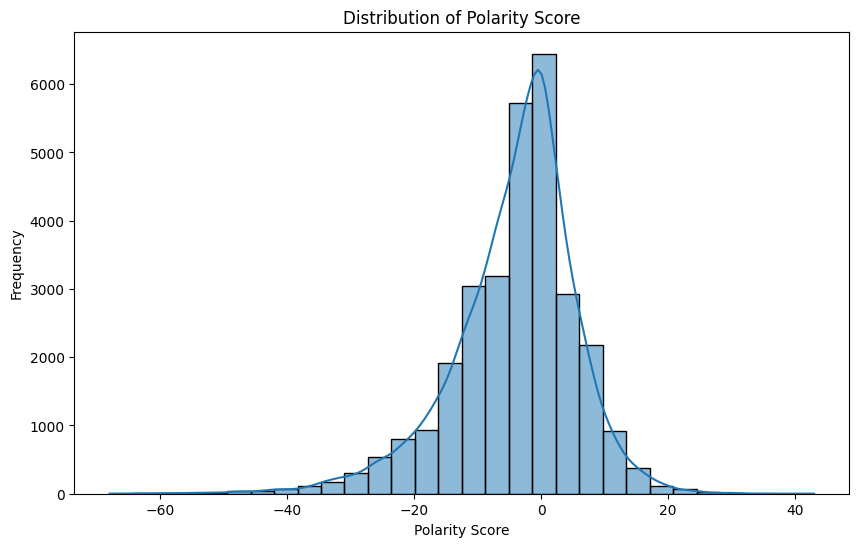

In [21]:
# Menampilkan distribusi polarity_score dengan histogram
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['polarity_score'], bins=30, kde=True)
plt.title('Distribution of Polarity Score')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

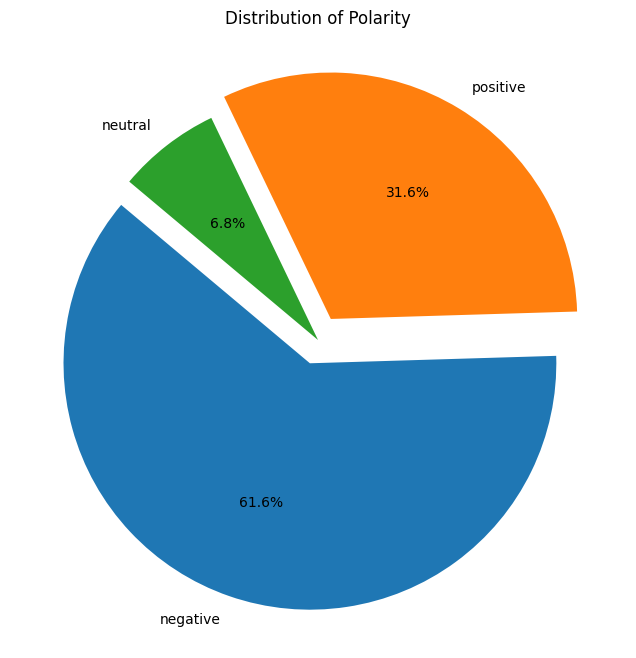

In [22]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = clean_df['polarity'].value_counts()

explode = (0.1, 0.1, 0)

# Menampilkan diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Distribution of Polarity')
plt.show()

In [23]:
# Membuat dataframe untuk wordcloud neutral
pd.set_option('display.max_colwidth', 3000)

neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

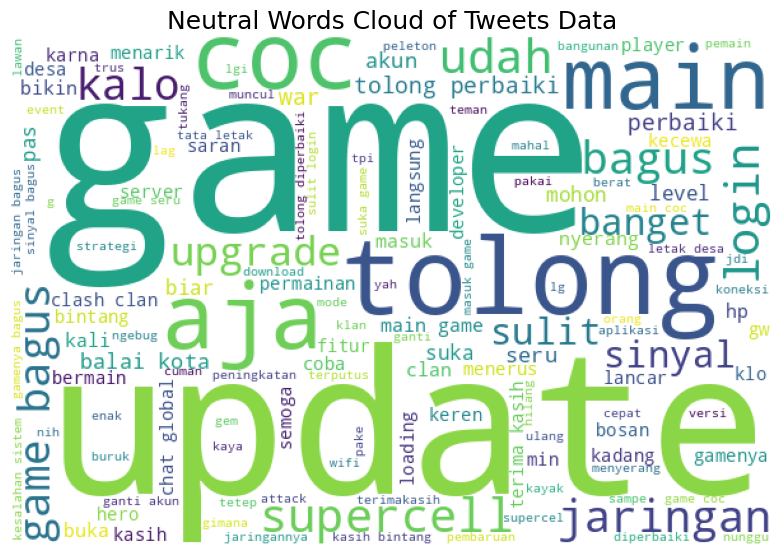

In [24]:
# Membuat wordcloud neutral
neutral_words = ''

for tweet in neutral_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'neutral_words'.
        neutral_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(neutral_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Neutral Words Cloud of Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [25]:
# Membuat dataframe untuk wordcloud positive
pd.set_option('display.max_colwidth', 3000)

positive_tweets = clean_df[clean_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

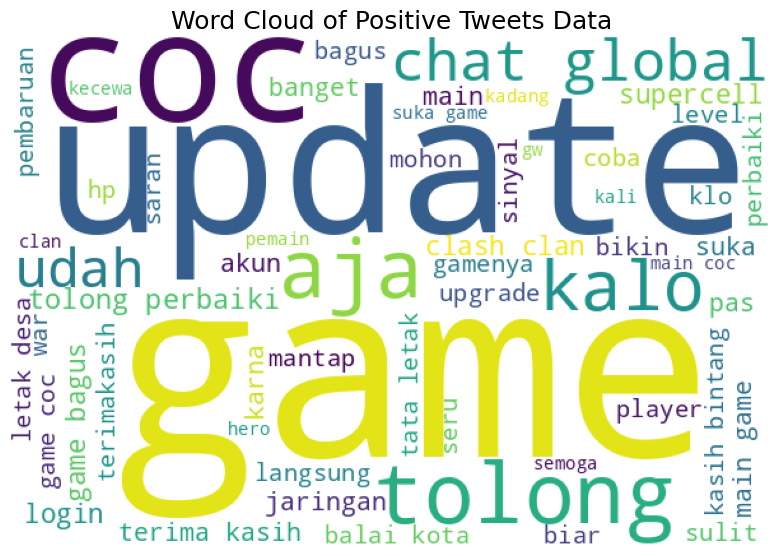

In [26]:
# Menampilkan wordcloud untuk label positive
positive_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'positive_words'.
        positive_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(positive_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

In [27]:
# Membuat dataframe untuk wordcloud negative
pd.set_option('display.max_colwidth', 3000)

negative_tweets = clean_df[clean_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

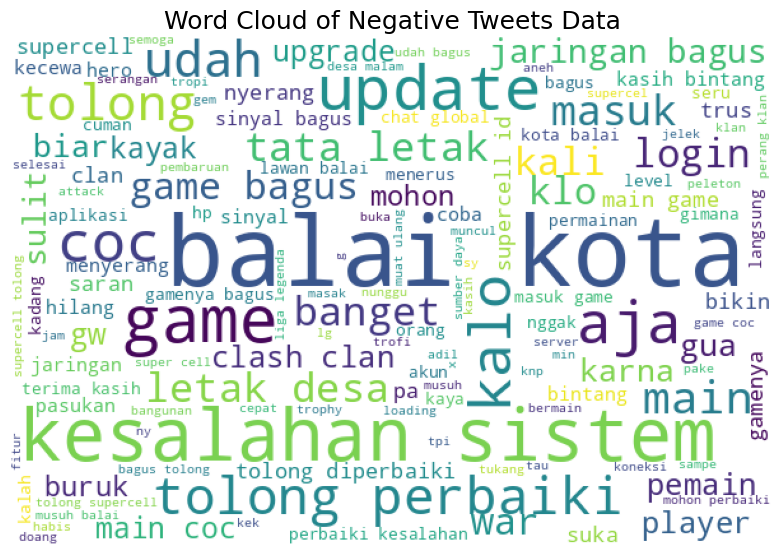

In [28]:
# Menampilkan wordcloud untuk label negative
negative_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'negative_words'.
        negative_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(negative_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

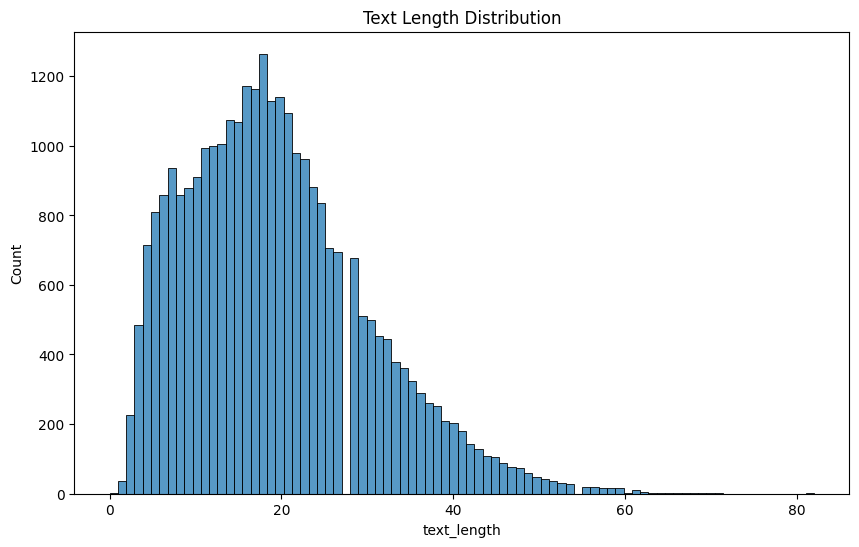

In [29]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize text length distribution
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

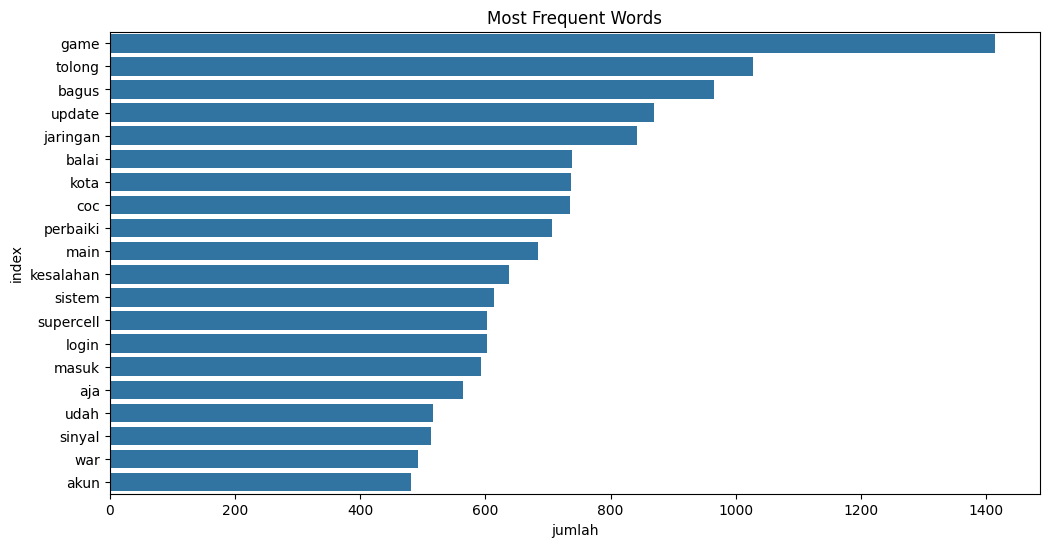

In [30]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

### Data Splitting

In [31]:
# Memisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_df['text_akhir']
y = clean_df['polarity']

### Feature Extraction

In [32]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=5000, min_df=50, max_df=0.9)
X_tfidf = tfidf.fit_transform(X)

In [33]:
# Ekstraksi fitur dengan Bag of Words (BoW)
# Inisialisasi CountVectorizer()
vectorizer = CountVectorizer(max_features=5000, min_df=50, max_df=0.9)

# Fitting dan Transformasi documents
X_bow = vectorizer.fit_transform(X)

### Modelling dengan 5 Skema

#### Skema 1: Random Forest, BoW, 60/40

In [34]:
# membagi data latih dan uji dengan fungsi train_test_split
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(X_bow, y, test_size=0.4, random_state=42)

In [35]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train_rf.toarray(), Y_train_rf)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train_rf.toarray())
y_pred_test_rf = random_forest.predict(X_test_rf.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, Y_train_rf)
accuracy_test_rf = accuracy_score(y_pred_test_rf, Y_test_rf)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9993887870200588
Random Forest - accuracy_test: 0.8013167763980331


#### Skema 2: Logistic Regression, TF-IDF, 70/30

In [36]:
# membagi data latih dan uji dengan fungsi train_test_split
X_train_lr, X_test_lr, Y_train_lr, Y_test_lr = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [37]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train_lr.toarray(), Y_train_lr)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train_lr.toarray())
y_pred_test_lr = logistic_regression.predict(X_test_lr.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, Y_train_lr)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, Y_test_lr)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.8869362289850931
Logistic Regression - accuracy_test: 0.8664296032892543


#### Skema 3: SVM, TF-IDF, 80/20

In [38]:
# membagi data latih dan uji dengan fungsi train_test_split
X_train_svm, X_test_svm, Y_train_svm, Y_test_svm = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [39]:
svm = SVC(kernel='linear', random_state=42)

svm.fit(X_train_svm.toarray(), Y_train_svm)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train_svm.toarray())
y_pred_test_svm = svm.predict(X_test_svm.toarray())

# Evaluasi akurasi model SVM pada data pelatihan
accuracy_train_svm = accuracy_score(y_pred_train_svm, Y_train_svm)

# Evaluasi akurasi model SVM Regression pada data uji
accuracy_test_svm = accuracy_score(y_pred_test_svm, Y_test_svm)

# Menampilkan akurasi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.8823970661776963
SVM - accuracy_test: 0.8693333333333333


#### Skema 4: CNN, Tokenizer, 80/20

In [40]:
# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y_to_cat = to_categorical(integer_encoded)

In [55]:
# Membuat callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92):
      print('\nAccuracy more than 92%')
      self.model.stop_training = True

my_callback = myCallback()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta = 0.01,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001
)

callbacks = [my_callback, early_stopping, reduce_lr]

In [56]:
# membagi data latih dan uji dengan fungsi train_test_split
X_train_cnn, X_test_cnn, Y_train_cnn, Y_test_cnn = train_test_split(X, y_to_cat, test_size=0.2, random_state=42)

In [57]:
# Preprocessing untuk model CNN
tokenizer = Tokenizer(num_words=10000,  oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_cnn)

X_train_seq_cnn = tokenizer.texts_to_sequences(X_train_cnn)
X_test_seq_cnn = tokenizer.texts_to_sequences(X_test_cnn)

X_train_pad_cnn = pad_sequences(X_train_seq_cnn, maxlen=100, padding="post", truncating="post")
X_test_pad_cnn = pad_sequences(X_test_seq_cnn, maxlen=100,  padding="post", truncating="post")

In [58]:
# Membangun model CNN
model_CNN = Sequential([
    Embedding(input_dim=10000, input_length=100, output_dim=100),
    Conv1D(128, kernel_size=5, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.8),
    BatchNormalization(momentum=0.99),
    Dense(3, activation="softmax")
])

# Mengcompile model
model_CNN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [59]:
# Pelatihan Model
hist_CNN = model_CNN.fit(X_train_pad_cnn, Y_train_cnn, batch_size=64, epochs=20, validation_data=(X_test_pad_cnn, Y_test_cnn), callbacks=callbacks)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.5418 - loss: 0.9356 - val_accuracy: 0.8283 - val_loss: 0.4782 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 49s 117ms/step - accuracy: 0.8354 - loss: 0.4736 - val_accuracy: 0.8568 - val_loss: 0.3725 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 89ms/step - accuracy: 0.8835 - loss: 0.3540 - val_accuracy: 0.8723 - val_loss: 0.3480 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.8982 - loss: 0.2937 - val_accuracy: 0.8705 - val_loss: 0.3481 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9076 - loss: 0.2575 - val_accuracy: 0.8727 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.9128 - loss: 0.2414 - val_accuracy: 0.8778 - val_loss: 0.3475 - learning_rate: 5.0000e-04
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.9

In [60]:
# Model evaluate
loss_cnn, accuracy_cnn = model_CNN.evaluate(X_test_pad_cnn, Y_test_cnn)
print("\nEvaluasi Model CNN:")
print(f"Accuracy CNN: {accuracy_cnn}")
print(f"Loss CNN: {loss_cnn}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8712 - loss: 0.3499

Evaluasi Model CNN:
Accuracy CNN: 0.8723333477973938
Loss CNN: 0.34802067279815674


#### Skema 5: LSTM, Tokenizer, 70/30

In [61]:
# membagi data latih dan uji dengan fungsi train_test_split
X_train_lstm, X_test_lstm, Y_train_lstm, Y_test_lstm = train_test_split(X, y_to_cat, test_size=0.3, random_state=42)

In [62]:
# Preprocessing untuk model LSTM
tokenizer.fit_on_texts(X_train_lstm)

X_train_seq_lstm = tokenizer.texts_to_sequences(X_train_lstm)
X_test_seq_lstm = tokenizer.texts_to_sequences(X_test_lstm)

X_train_pad_lstm = pad_sequences(X_train_seq_lstm, maxlen=100, padding="post", truncating="post")
X_test_pad_lstm = pad_sequences(X_test_seq_lstm, maxlen=100,  padding="post", truncating="post")

In [63]:
# Membangun model LSTM
model_LSTM = Sequential([
    Embedding(input_dim=10000, input_length=100, output_dim=100),
    LSTM(64, kernel_regularizer='l2'),
    Dense(64, activation="relu"),
    Dropout(0.8),
    BatchNormalization(momentum=0.99),
    Dense(3, activation="softmax")
])

# Mengcompile model
model_LSTM.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [64]:
# Pelatihan Model
hist_LSTM = model_LSTM.fit(X_train_pad_lstm, Y_train_lstm, batch_size=64, epochs=20, validation_data=(X_test_pad_lstm, Y_test_lstm), callbacks=callbacks)

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 54s 151ms/step - accuracy: 0.5349 - loss: 1.7829 - val_accuracy: 0.6204 - val_loss: 0.9183 - learning_rate: 5.0000e-04
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 87s 166ms/step - accuracy: 0.6084 - loss: 0.9049 - val_accuracy: 0.6204 - val_loss: 0.8481 - learning_rate: 5.0000e-04
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 50s 153ms/step - accuracy: 0.6144 - loss: 0.8533 - val_accuracy: 0.6204 - val_loss: 0.8402 - learning_rate: 5.0000e-04
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 88s 171ms/step - accuracy: 0.6094 - loss: 0.8541 - val_accuracy: 0.6204 - val_loss: 0.8384 - learning_rate: 5.0000e-04
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 75s 152ms/step - accuracy: 0.6100 - loss: 0.8495 - val_accuracy: 0.6204 - val_loss: 0.8384 - learning_rate: 5.0000e-04
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 148ms/step - accuracy: 0.6096 - loss: 0.8492 - val_accuracy: 0.6204 - val_loss: 0.8385 - learning_rate: 5.0000e-04
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 98s 19

In [67]:
# Model evaluate
loss_lstm, accuracy_lstm = model_LSTM.evaluate(X_test_pad_lstm, Y_test_lstm)
print("\nEvaluasi Model LSTM:")
print(f"Accuracy LSTM: {accuracy_lstm}")
print(f"Loss LSTM: {loss_lstm}")

282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.6242 - loss: 0.8464

Evaluasi Model LSTM:
Accuracy LSTM: 0.6204022765159607
Loss LSTM: 0.8481185436248779


### Testing

#### Testing semua model

In [82]:
# Input kalimat baru dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")
actual = input("Masukkan nilai aktual prediksi: ")

# Melakukan preprocessing pada kalimat baru
kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)

# Menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
X_kalimat_tfidf = tfidf.transform([kalimat_baru_final])
X_kalimat_bow = vectorizer.transform([kalimat_baru_final])

X_kalimat_seq = tokenizer.texts_to_sequences(kalimat_baru_final)
X_kalimat_tokenizer = pad_sequences(X_kalimat_seq, maxlen=100)

# Memperoleh prediksi sentimen kalimat baru
prediksi_rf = random_forest.predict(X_kalimat_bow.toarray())
prediksi_lr = logistic_regression.predict(X_kalimat_tfidf.toarray())
prediksi_svm = svm.predict(X_kalimat_tfidf.toarray())
prediksi_CNN = model_CNN.predict(X_kalimat_tokenizer)
prediksi_LSTM = model_LSTM.predict(X_kalimat_tokenizer)

# Menampilkan hasil prediksi
print('input user: ', kalimat_baru)
# Mengubah prediksi menjadi label
predicted_cnn = np.argmax(prediksi_CNN, axis=1)
cnn_prediksi = labelencoder.inverse_transform(predicted_cnn)

predicted_lstm = np.argmax(prediksi_LSTM, axis=1)
lstm_prediksi = labelencoder.inverse_transform(predicted_lstm)

# Data hasil prediksi dari berbagai model untuk dataframe
results = {
    "Model": ["Random Forest", "Logistic Regression", "SVM", "CNN", "LSTM"],
    "Prediksi": [prediksi_rf[0], prediksi_lr[0], prediksi_svm[0], cnn_prediksi[0], lstm_prediksi[0]],
    "Actual": [actual] * 5,  # Sama untuk semua model
    "Akurasi": [accuracy_test_rf, accuracy_test_lr, accuracy_test_svm, accuracy_cnn, accuracy_lstm]
}

# Menampilkan hasil prediksi
result_df = pd.DataFrame(results)
result_df

Masukkan kalimat baru: Saya suka game ini
Masukkan nilai aktual prediksi: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
input user:  Saya suka game ini


,Model,Prediksi,Actual,Akurasi
0,Random Forest,positive,positive,0.801317
1,Logistic Regression,positive,positive,0.866430
2,SVM,positive,positive,0.869333
3,CNN,positive,positive,0.872333
4,LSTM,negative,positive,0.620402


#### Testing and Get Best Models Based on Last Testing

In [83]:
answer = {
    'Random Forest': [prediksi_rf[0], actual, accuracy_test_rf],
    'Logistic Regression': [prediksi_lr[0], actual, accuracy_test_lr],
    'SVM': [prediksi_svm[0], actual, accuracy_test_svm],
    'CNN': [cnn_prediksi[0], actual, accuracy_cnn],
    'LSTM': [lstm_prediksi[0], actual, accuracy_lstm]
}

In [84]:
# Melakukan pengambilan model berdasarkan hasil actual dan prediksi
def get_model(models):
  best_models = {}
  for model, val in models.items():
    prediksi = val[0]
    actual = val[1]
    accuracy = val[2]

    if prediksi.lower() == actual.lower():
       best_models[model] = accuracy

  return best_models

In [85]:
# Membuat map model untuk menampung hasil dari get_model
accuracies = get_model(answer)
print(accuracies)

# Membuat fungsi untuk mendapatkan best model
def best_model(acc):
  best_model_name = max(acc, key=acc.get)
  if best_model_name == 'Random Forest':
    return random_forest, best_model_name
  elif best_model_name == 'Logistic Regression':
    return logistic_regression, best_model_name
  elif best_model_name == 'SVM':
    return svm, best_model_name
  elif best_model_name == 'CNN':
    return model_CNN, best_model_name
  else:
    return model_LSTM, best_model_name

{'Random Forest': 0.8013167763980331, 'Logistic Regression': 0.8664296032892543, 'SVM': 0.8693333333333333, 'CNN': 0.8723333477973938}


In [86]:
model, model_name = best_model(accuracies)
if model_name == "Logistic Regression" or model_name == "Random Forest" or model_name == "SVM":
  pickle.dump(model, open('best_model', 'wb'))
else:
  model.save('best_model.h5')
print(f"Model terbaik: {model_name}")

Model terbaik: CNN


In [88]:
# Input kalimat baru dari pengguna
kalimat_baru = input("Masukkan kalimat baru: ")

# Melakukan preprocessing pada kalimat baru
kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)

# Menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
X_kalimat_baru = ''
if model_name == "Logistic Regression" or model_name == "SVM":
  X_kalimat_baru = tfidf.transform([kalimat_baru_final])
elif model_name == "Random Forest":
  X_kalimat_baru = vectorizer.transform([kalimat_baru_final])
else:
  X_kalimat_seq = tokenizer.texts_to_sequences(kalimat_baru_final)
  X_kalimat_baru = pad_sequences(X_kalimat_seq, maxlen=100)

# Memperoleh prediksi sentimen kalimat baru
prediksi_sentimen = model.predict(X_kalimat_baru)

# Menampilkan hasil prediksi
print('input user: ', kalimat_baru)
# Mengubah prediksi menjadi label
answer = ''
if model_name == "Logistic Regression" or model_name == "SVM" or model_name == "Random Forest":
  answer = prediksi_sentimen
else:
  predicted_labels = np.argmax(prediksi_sentimen, axis=1)
  answer = labelencoder.inverse_transform(predicted_labels)

# Menampilkan hasil prediksi
if answer[0] == 'positive':
  print("Sentimen kalimat baru adalah POSITIF.")
elif answer[0] == 'neutral':
  print("Sentimen kalimat baru adalah NEUTRAL")
else:
  print("Sentimen kalimat baru adalah NEGATIF.")

Masukkan kalimat baru: Saya suka game ini
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
input user:  Saya suka game ini
Sentimen kalimat baru adalah POSITIF.
